# Tutorial: Geometric Deep Learning with PyTorch

## Setup

In [1]:
import torch
import torchmetrics
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
from typing import List
from tqdm import tqdm

If you are working with Google Colab and would like to activate a GPU, open the *Runtime* drop-down menu, click on *Change runtime type*, and then choose GPU as hardware accelerator.

In [2]:
if torch.cuda.is_available():
    device = "cuda"
elif torch.mps.is_available():
    device = "mps"
else:
    device = "cpu"
device

'mps'

## Part 1: PyTorch

[PyTorch](https://pytorch.org/) is an open source machine learning framework, which is based on tensor manipulation and automatic differentiation.

### Tensor Manipulation

Torch tensors can be manipulated just like numpy arrays and they support all algebraic manipulations.

In [3]:
a = torch.tensor([[1, 0], [0, 2]])

b = torch.tensor([[0, 3], [4, 0]])

################################################################################

print("a + b:")
print(a + b)

print("a * b")
print(a * b)

print("a @ b")
print(a @ b)

print("2.5 * a")
print(2.5 * a)

print("1 + a")
print(1 + a)

a + b:
tensor([[1, 3],
        [4, 2]])
a * b
tensor([[0, 0],
        [0, 0]])
a @ b
tensor([[0, 3],
        [8, 0]])
2.5 * a
tensor([[2.5000, 0.0000],
        [0.0000, 5.0000]])
1 + a
tensor([[2, 1],
        [1, 3]])


### Modules

In PyTorch, neural networks are defined using [`Modules`](https://pytorch.org/docs/stable/notes/modules.html), which serve as building blocks for models. Each module implements a `forward` method that defines how input data flows through the network using differentiable operations. The backward pass, which computes gradients, is handled automatically by PyTorch's autograd system based on the operations defined in the forward method.

The `torch.nn` module provides many popular neural network layers, which can be composed out of the box. You can have a look at the [documentation](https://pytorch.org/docs/stable/nn.html) for a complete list of available layers.

In [4]:
# Let's generate a random design matrix
X = torch.empty(5, 10).normal_()
X

tensor([[-0.1547, -1.0684, -1.0103,  1.2720, -0.0365, -0.4767, -0.3865,  0.2433,
          0.5079, -0.4579],
        [-0.0926, -2.0023, -0.1799, -0.0878, -1.0416,  0.4952,  1.0442, -1.5885,
          0.8281, -1.4430],
        [-0.6749, -0.2656, -0.3939, -0.7876, -0.1296, -0.6300, -1.2767,  0.3471,
         -0.4939,  0.0308],
        [-0.3742, -0.4175,  0.1233,  0.9079, -0.6531, -1.0697,  0.2027, -0.9735,
         -0.3368,  1.6395],
        [-0.0282,  1.5766, -0.3879, -0.4260, -0.3526, -1.4145, -0.3283,  1.5307,
         -1.3369, -0.4194]])

In [5]:
# Let's apply a Linear (fully connected) layer
linear = nn.Linear(
    in_features=10,
    out_features=2,
)

out = linear(X)
out

tensor([[ 0.0049, -0.3386],
        [-0.2792, -0.7762],
        [-0.0970, -0.5863],
        [ 0.4489,  0.4836],
        [-0.0751, -0.0200]], grad_fn=<AddmmBackward0>)

We can define custom modules by inheriting from the `toch.nn.Module` base class and defining the `forward` method.

In [6]:
class MyLinear(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.weight = nn.Parameter(torch.randn(in_features, out_features))
        self.bias = nn.Parameter(torch.randn(out_features))

    def forward(self, input):
        return (input @ self.weight) + self.bias

In [7]:
my_linear = MyLinear(10, 2)
my_linear(X)

tensor([[ 3.5286, -2.5127],
        [-5.6633, -4.9189],
        [ 2.1650, -0.1703],
        [-0.0094,  3.0366],
        [ 3.0301, -0.6498]], grad_fn=<AddBackward0>)

### Neural Networks

Feedforward neural networks are a stack of layers where data flows from the input layer, through one or more hidden layers, to the output layer.

In [8]:
mlp = nn.Sequential(
    nn.Linear(10, 20),
    nn.ReLU(),
    nn.Linear(20, 2),
    nn.Softmax(dim=-1),
)

In [9]:
mlp(X)

tensor([[0.4846, 0.5154],
        [0.5220, 0.4780],
        [0.5523, 0.4477],
        [0.4291, 0.5709],
        [0.4922, 0.5078]], grad_fn=<SoftmaxBackward0>)

For more flexibility, we can define neural networks as Modules.

In [10]:
class MLP(nn.Module):
    def __init__(self, nb_in: int, nb_hidden: int, nb_out: int) -> None:
        super().__init__()
        self.l1 = nn.Linear(nb_in, nb_hidden)
        self.l2 = nn.Linear(nb_hidden, nb_hidden)
        self.l3 = nn.Linear(nb_hidden, nb_out)

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        X = torch.relu(self.l1(X))
        X = torch.relu(self.l2(X))
        return torch.softmax(self.l3(X), dim=-1)

In [11]:
mlp2 = MLP(10, 20, 2)
mlp2

MLP(
  (l1): Linear(in_features=10, out_features=20, bias=True)
  (l2): Linear(in_features=20, out_features=20, bias=True)
  (l3): Linear(in_features=20, out_features=2, bias=True)
)

In [12]:
mlp2(X)

tensor([[0.5041, 0.4959],
        [0.4990, 0.5010],
        [0.5397, 0.4603],
        [0.5275, 0.4725],
        [0.5262, 0.4738]], grad_fn=<SoftmaxBackward0>)

### Using GPUs

All tensors and modules can be moved to GPU using the `.to(...)` method. Pay attention that everything shall be moved to the same "device"!


In [13]:
X = X.to(device)
mlp.to(device)

# Verify the device of your objects
print(f"X: {X.device}, output: {mlp(X).device}")

X: mps:0, output: mps:0


## Part 2: Training Neural Networks

### Datasets and Dataloaders

PyTorch offers utilities for loading and batching data, along with a wide selection of ready-to-use datasets.

In [14]:
from torchvision import transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader

We use the MNIST dataset for this part of the tutorial, which is readily available in PyTorch.

In [15]:
# We convert images to tensors and normalize them
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)),
    ]  # Mean and std are well known
)
dataset_tr = MNIST(".", transform=transform, train=True, download=True)
dataset_te = MNIST(".", transform=transform, train=False, download=True)

# Lets wrap the dataset in a dataloader to get batched samples
BATCH_SIZE = 64
loader_tr = DataLoader(dataset_tr, batch_size=BATCH_SIZE)
loader_te = DataLoader(dataset_te, batch_size=BATCH_SIZE)

The MNIST dataset contains 28x28 grayscale images of handwritten digits that we would like to identify.

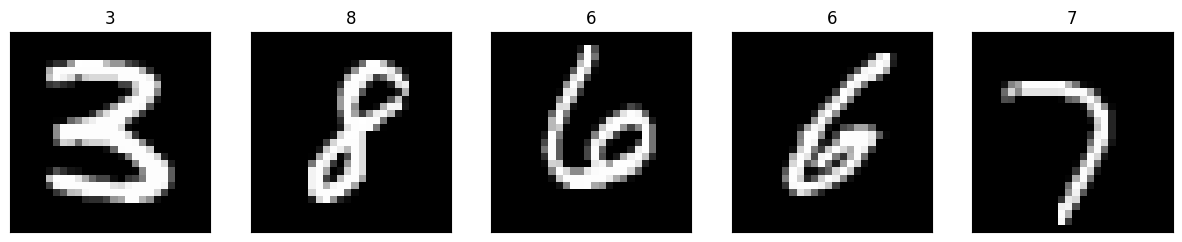

In [16]:
def plot_random_sample(ax):
    X, y = dataset_tr[torch.randint(len(dataset_tr), (1,)).item()]

    ax.imshow(X[0].numpy() * 0.3081 + 0.1307, cmap="gray")
    ax.set(title=y)


fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for ax in axes:
    plot_random_sample(ax)
    ax.set(xticks=[], yticks=[])
plt.show()

### Loss Functions

PyTorch comes with many loss functions in the `torch.nn` module. For a complete list you can refer to the [documentation](https://pytorch.org/docs/stable/nn.html#loss-functions).

For our handwritten-digit classification task a good choice is the [cross entropy loss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss), which takes raw class scores and  compares them to the desired class labels.

In [17]:
loss_fn = nn.CrossEntropyLoss()

loss_fn(
    torch.tensor([[0, 10, 2], [11, 6, 5], [13, 20, 1], [2, 7, 15]], dtype=torch.float),
    torch.tensor([1, 0, 0, 2]),
)

tensor(1.7527)

### Training Loop

Neural networks are trained using Stochastic Gradient Descent (SGD) or its variants. An epoch consists of performing one gradient update per batch, covering the entire training dataset once.

In [18]:
# Lets define a feedforward convolutional neural network (CNN)
cnn = nn.Sequential(
    nn.Conv2d(1, 4, 5),  # out_size: (4, 24, 24)
    nn.ReLU(),
    nn.Conv2d(4, 16, 5),  # out_size: (16, 20, 20)
    nn.ReLU(),
    nn.Conv2d(16, 16, 5),  # out_size: (16, 16, 16),
    nn.ReLU(),
    nn.Flatten(),  # out_size: (4096),
    nn.Linear(4096, 512),
    nn.ReLU(),
    nn.Linear(512, 10),
).to(device)

# Note that we moved it to GPU!

SGD is an optimization algorithm and PyTorch implements it, along with many others, in the `torch.optim` module (see the [documentation](https://pytorch.org/docs/stable/optim.html)). These "optimizers" handle the update of the desired parameters through a `step()` method which they all implement.


In [19]:
optimizer = torch.optim.SGD(
    params=cnn.parameters(),
    lr=1e-3,
)

In [20]:
def train_step(
    model: nn.Module,
    optimizer: torch.optim.Optimizer,
    loss_fn: nn.Module,
    X: torch.Tensor,
    y: torch.Tensor,
) -> torch.Tensor:
    # Start by resetting the optimizer
    optimizer.zero_grad()

    # Compute the model predictions and their loss
    out = model(X)
    loss = loss_fn(out, y)

    # Compute gradients
    loss.backward()

    # Perform the optimization step
    optimizer.step()

    return loss

Now let's optimize our CNN!

In [21]:
NB_EPOCHS = 5
nb_batches = round(len(dataset_tr) / BATCH_SIZE)

for epoch in range(NB_EPOCHS):
    for X, y in tqdm(loader_tr, total=nb_batches, desc=f"Epoch {epoch+1}"):
        X, y = X.to(device), y.to(device)

        loss = train_step(cnn, optimizer, loss_fn, X, y)

Epoch 5: 100%|██████████| 938/938 [00:03<00:00, 242.60it/s]


### Evaluation

Now that the model is trained, it's time to evaluate it. To compute metrics, we use the [TorchMetrics](https://torchmetrics.readthedocs.io/en/latest/) library, which we already installed in the setup. We are mainly interested in the accuracy of our model, so let's compute it!

In [22]:
def evaluate(model: nn.Module, metric: torchmetrics.Metric, loader: DataLoader):
    with torch.no_grad():
        for X, y in tqdm(loader, total=len(loader)):
            X, y = X.to(device), y.to(device)
            # Compute probabilities
            preds = model(X).softmax(dim=-1)

            # Metric on current batch
            _ = metric(preds, y)

        # Accumulated metric (on all batches)
        return metric.compute()

In [23]:
accuracy_fn = torchmetrics.Accuracy(task="multiclass", num_classes=10).to(device)
acc_tr = evaluate(cnn, accuracy_fn, loader_tr)

accuracy_fn.reset()  # Reset the accuracy!
acc_te = evaluate(cnn, accuracy_fn, loader_te)

print(f"Train accuracy: {acc_tr:.2%}")
print(f"Test accuracy:  {acc_te:.2%}")

100%|██████████| 157/157 [00:00<00:00, 252.71it/s]

Train accuracy: 93.67%
Test accuracy:  94.08%


Not bad for a first try! 🎉

## Part 3: PyTorch Geometric

Now that we are acquainted with PyTorch, let's plug in graph data! 😁

Our framework of choice is [PyTorch Geometric][1], a useful extension of PyTorch designed to work with graphs. This tutorial will be a quick overview of a few of its main features, and you can complete it by checking out the [documentation][1] and the [official tutorials][2].


[1]: https://pytorch-geometric.readthedocs.io/en/latest/
[2]: https://pytorch-geometric.readthedocs.io/en/latest/notes/colabs.html

### PyG Data

A single graph in PyTorch Geometric is described by an instance of `torch_geometric.data.Data`, which can hold several attributes, among which:

* `data.x`: Node feature matrix with shape `[num_nodes, num_node_features]`

* `data.edge_index`: Graph connectivity tensor with shape `[2, num_edges]` and type `torch.long`. Note that one would expect the **node pairs** to be saved as rows, but in this format they are **saved as columns** of the `edge_index` matrix.

* `data.edge_attr`: Edge feature matrix with shape `[num_edges, num_edge_features]`

* `data.y`: Target to train against, e.g., node-level targets of shape `[num_nodes, *]` or graph-level targets of shape `[1, *]`

Not all of these fields must be present and the user can define his own attributes. The following cell shows an example for the creation of a simple graph in PyTorch Geometric.


In [24]:
import torch_geometric as pyg
from torch_geometric.data import Data

In [25]:
## Create an undirected graph having three nodes (0, 1, 2).
## Nodes 0 and 1 are connected and nodes 1 and 2 are connected (in both directions).
## Each node has a single feature. These features are equal to -1, 0, 1 for the three nodes respectively, in this order.
edge_index = torch.tensor([[0, 1, 1, 2], [1, 0, 2, 1]], dtype=torch.long)
x = torch.tensor([[-1], [0], [1]], dtype=torch.float)

G1 = Data(x=x, edge_index=edge_index)

As you can see, it is very close to Networkx, and utility functions can map back and forth from one to the other.

In [26]:
from torch_geometric.utils import to_networkx, from_networkx

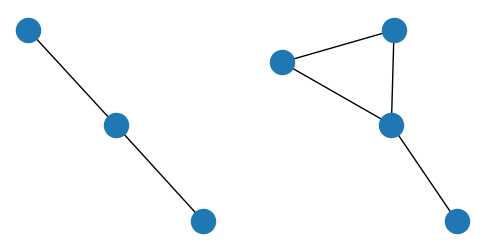

tensor([[0, 1, 1, 1, 2, 2, 3, 3],
        [1, 0, 2, 3, 1, 3, 1, 2]])


In [27]:
Gnx = to_networkx(G1, to_undirected=True)

fig, axes = plt.subplots(1, 2, figsize=(6, 3))
nx.draw(Gnx, ax=axes[0])

Gnx.add_node(3)
Gnx.add_edges_from([(1, 3), (2, 3)])
nx.draw(Gnx, ax=axes[1])
plt.show()

G2 = from_networkx(Gnx)
print(G2.edge_index)

### PyG Datasets and Dataloaders

PyG implements its own wrappers of `Dataset` and `DataLoader`. They provide the same interface as regular PyTorch, but instead of Tensors they return instances of `Data`. PyG comes with some ready-to-use datasets, such as the Karate Club.

Dataset: KarateClub():
Number of graphs: 1
Number of features: 34
Number of classes: 4


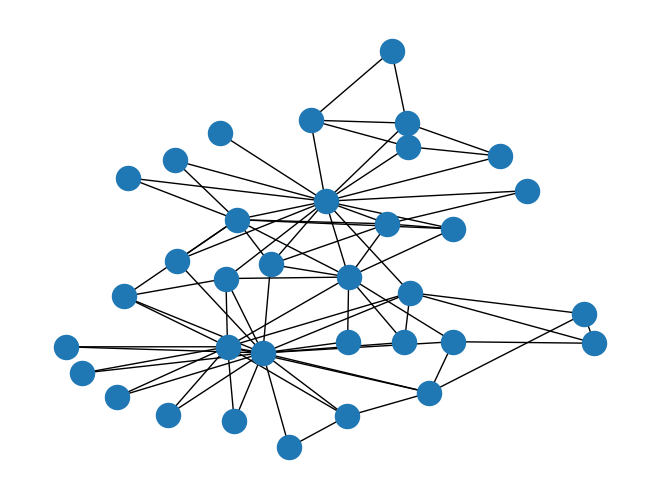

In [28]:
from torch_geometric.datasets import KarateClub

# Load the dataset
dataset = KarateClub()

print(f"Dataset: {dataset}:")
print("======================")
print(f"Number of graphs: {len(dataset)}")
print(f"Number of features: {dataset.num_features}")
print(f"Number of classes: {dataset.num_classes}")

# Let's draw it
nx.draw_kamada_kawai(to_networkx(dataset[0], to_undirected=True))

Processing...


Dataset: Mutagenicity(4337):
Number of graphs: 4337
Number of features: 14
Number of classes: 2


Done!


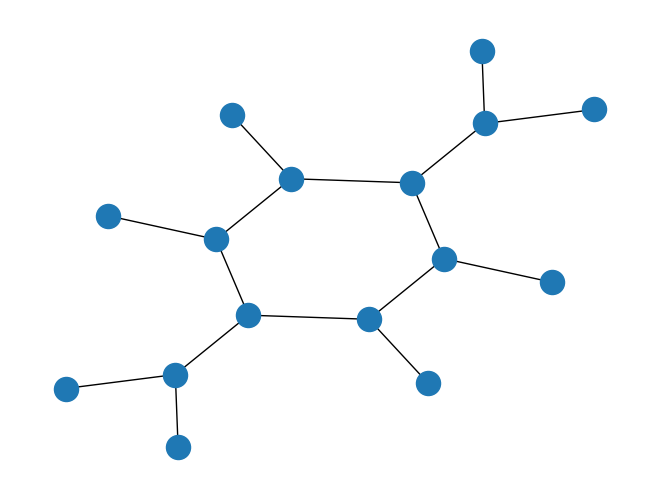

In [29]:
from torch_geometric.datasets import TUDataset

# Load the dataset
dataset = TUDataset(root=".", name="Mutagenicity")

print(f"Dataset: {dataset}:")
print("======================")
print(f"Number of graphs: {len(dataset)}")
print(f"Number of features: {dataset.num_features}")
print(f"Number of classes: {dataset.num_classes}")

# Let's draw a sample
nx.draw_kamada_kawai(to_networkx(dataset[0], to_undirected=True))

Custom datasets can be defined as well, by inheriting from the `torch_geometric.data.Dataset` class, and defining the following methods:

- `torch_geometric.data.Dataset.len()`: Returns the number of examples in your dataset.
- `torch_geometric.data.Dataset.get()`: Implements the logic to load a single graph.



See [Creating Your Own Datasets][^1] for more info.

[^1]: https://pytorch-geometric.readthedocs.io/en/latest/notes/create_dataset.html#

In [30]:
class RandomGraphs(pyg.data.Dataset):
    def __init__(self, nb_graphs: int):
        super().__init__()

        self.graph_list = []
        for _ in range(nb_graphs):
            G = nx.erdos_renyi_graph(10, 0.4)
            self.graph_list.append(from_networkx(G))

    def len(self) -> int:
        return len(self.graph_list)

    def get(self, index: int) -> Data:
        return self.graph_list[index]

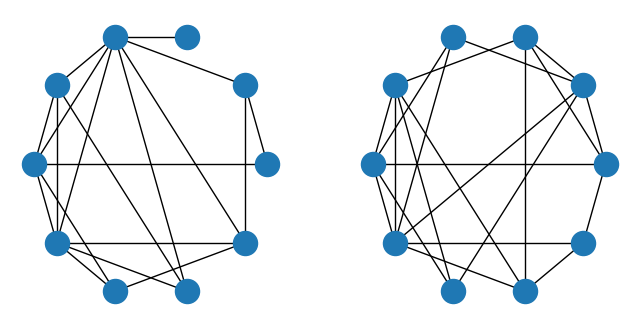

In [31]:
rand_graphs = RandomGraphs(5)

fig, axes = plt.subplots(1, 2, figsize=(8, 4))
nx.draw_circular(to_networkx(rand_graphs[0], to_undirected=True), ax=axes[0])
nx.draw_circular(to_networkx(rand_graphs[3], to_undirected=True), ax=axes[1])

For efficiency reasons, a Pytorch Geometric Dataloader builds a batch of graphs by considering it as a unique big graph: the big graph adjacency matrix is built by stacking diagonally the adjacency matrices of the graphs in the batch (which are defined by `edge_index`). Features and target matrices are concatenated in the node dimension. This composition allows differing number of nodes and edges over examples in one batch.

$$  A =
  \begin{bmatrix}
    A_{1} & & \\
    & \ddots & \\
    & & A_{N}
  \end{bmatrix}, \quad X = \begin{bmatrix}
X_1\\ 
\vdots \\ 
X_N
\end{bmatrix}, \quad Y = \begin{bmatrix}
Y_1\\ 
\vdots\\
Y_N
\end{bmatrix}$$

A batch of graphs will contain the `batch` attribute, which is a tensor whose length is equal to the number of nodes in the big graph obtained by the union of all the graphs in the batch. Such tensor maps each node to the index of the graph that node originally came from. Thus, this allows for recovering the original graphs from a batch coming form the dataloader. Luckily, you will not have to handle this, but it is good to understand it nonetheless. This batching strategy allows us to learn local models on huge graphs just by looking at $n$-hop neighborhoods, instead of loading all data, for instance.


In [32]:
# Split dataset in train and test
split_idx = round(len(dataset) * 0.7)
dataset_tr = dataset[:split_idx]
dataset_te = dataset[split_idx:]

BATCH_SIZE = 16
loader_tr = pyg.loader.DataLoader(dataset_tr, batch_size=BATCH_SIZE, shuffle=True)
loader_te = pyg.loader.DataLoader(dataset_te, batch_size=BATCH_SIZE)

In [33]:
data_batch = next(iter(loader_tr))
print(data_batch)
print("Number of graphs in the batch:", data_batch.num_graphs)

DataBatch(edge_index=[2, 1092], x=[533, 14], edge_attr=[1092, 3], y=[16], batch=[533], ptr=[17])
Number of graphs in the batch: 16


### Graph Neural Networks

Graph Neural Networks can be implemented just like regular neural networks in PyTorch, i.e. as `nn.Module`s. One should be careful to include, in the forward pass, all arguments required by the graph layers. Generally those are the `edge_index` and the `batch` attributes of data, on top of the features.

In [34]:
def gnn_evaluate(
    gnn: nn.Module, metrics: List[torchmetrics.Metric], loader: DataLoader
):
    with torch.no_grad():
        gnn.eval()
        for batch in tqdm(loader, total=len(loader)):
            batch.to(device)
            # Compute probabilities
            preds = gnn(batch.x, batch.edge_index, batch.batch).softmax(dim=-1)

            # Metric on current batch
            for metric in metrics:
                _ = metric(preds, batch.y)

        # Accumulated metric (on all batches)
        return metrics

In [35]:
class GNN(nn.Module):
    def __init__(self, num_node_features: int, num_classes: int):
        super().__init__()

        self.conv1 = pyg.nn.GraphConv(num_node_features, 64)
        self.conv2 = pyg.nn.GraphConv(64, 64)
        self.conv3 = pyg.nn.GraphConv(64, 128)
        self.conv4 = pyg.nn.GraphConv(128, 128)
        self.conv5 = pyg.nn.GraphConv(128, 256)

        self.linear1 = nn.Linear(256, num_classes)

    def forward(self, x, edge_index, batch=None):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index).relu()
        x = self.conv3(x, edge_index).relu()
        x = self.conv4(x, edge_index).relu()
        x = self.conv5(x, edge_index).relu()

        x = pyg.nn.global_add_pool(x, batch)
        return self.linear1(x)

In [36]:
gnn = GNN(
    num_node_features=dataset.num_node_features,
    num_classes=2,
).to(device)

optimizer = torch.optim.SGD(gnn.parameters(), lr=1e-3)

loss_fn = nn.CrossEntropyLoss().to(device)

In [37]:
NB_EPOCHS = 15

for epoch in range(NB_EPOCHS):
    for batch in tqdm(loader_tr, desc=f"Epoch {epoch+1}"):
        batch.to(device)

        out = gnn(batch.x, batch.edge_index, batch.batch)
        loss = loss_fn(out, batch.y.flatten())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

Epoch 15: 100%|██████████| 190/190 [00:50<00:00,  3.80it/s]


In [38]:
accuracy_fn = torchmetrics.Accuracy(task="multiclass", num_classes=2).to(device)
confusion_fn = torchmetrics.ConfusionMatrix(task="multiclass", num_classes=2).to(device)

metrics = [accuracy_fn, confusion_fn]

gnn_evaluate(gnn, metrics, loader_tr)
acc_tr = accuracy_fn.compute()
conf_tr = confusion_fn.compute().cpu().numpy()

# Reset the metrics!
for metric in metrics:
    metric.reset()

gnn_evaluate(gnn, metrics, loader_te)
acc_te = accuracy_fn.compute()
conf_te = confusion_fn.compute().cpu().numpy()

print(f"Train accuracy: {acc_tr:.2%}")
print(conf_tr)
print(f"Test accuracy:  {acc_te:.2%}")
print(conf_te)

100%|██████████| 82/82 [00:12<00:00,  6.40it/s]

Train accuracy: 75.66%
[[1294  383]
 [ 356 1003]]
Test accuracy:  73.79%
[[548 176]
 [165 412]]


Again, pretty cool results! 🥳

## Part 4: Splitting Graph Data

In the previous sections, we encontered training and test data, without explaining what they are, or how we obtain them.

### Definitions

- **Train data** is the dataset used to train the model. The model learns the objective function by observing these samples and adjusting its parameters, denoted as $\mathbf{\Theta}$, to minimize the loss function $f(\mathcal{D}_{tr}, \mathbf{\Theta})$.
- **Test data** is a completely independent dataset, $\mathcal{D}_{te}$ that the model has never seen during training. It is used to estimate the model’s *expected performance*, i.e., its average performance on unseen real-world data.
- **Validation data** is another independent set of samples used during the training process to tune *hyperparameters*, i.e., configuration settings of the model that are not learned via gradient descent. In some cases, rather than having a fixed validation set, *cross-validation* techniques are employed.

It is extremely important to always use a *test dataset* to report performances of your models, which is why an independent validation dataset shall be used for model selection.

Generally, when we are provided a dataset, we obtain these splits with a random partition. Based on the amount of data, we choose how much to use for each split. A common option is to use 30% for test, 20% for validation, and 50% for train.

### Network Data

When working with network data, the extraction of the three splits depends on the kind of task that we want to solve.

#### Node-level tasks

For node-level tasks, each node is a sample, and often they come from a single graph. In this case, we obtain the splits using non-overlapping **masks**.


In [39]:
from torch_geometric.datasets import KarateClub

dataset = KarateClub()

print("Nb samples:", len(dataset))

data = dataset[0].to(device)
print("Nb nodes:", data.num_nodes)

Nb samples: 1
Nb nodes: 34


In [40]:
# Create a random number generator
from numpy.random import default_rng

rng = default_rng(seed=2106)

train_mask = np.zeros(data.num_nodes, dtype=bool)
train_mask[:10] = True
rng.shuffle(train_mask)

# The test mask should be the negation of the train mask
test_mask = ~train_mask

# Verify that train and test are disjoint
np.all(test_mask != train_mask)

True

In [41]:
# In training we compute the loss only on the training data
train_mask = torch.tensor(train_mask, device=device).bool()
model = pyg.nn.GCNConv(34, 4).to(device)
loss_fn = nn.CrossEntropyLoss().to(device)

out = model(data.x, data.edge_index)  # Perform a single forward pass.
loss = loss_fn(
    out[train_mask], data.y[train_mask]
)  # Compute the loss solely based on the training nodes.
out.size(), out[train_mask].size(), data.y[train_mask].size()

(torch.Size([34, 4]), torch.Size([10, 4]), torch.Size([10]))

**Attention!** Shuffling masks can make them overlap. Always define the test mask as the opposite of the train mask. The validation mask should be extracted from the train.


#### Graph-level tasks

In this case samples are single graphs and thus we can easily partition the dataset by randomly assigning graphs to each split.

In [42]:
# Load the dataset
dataset = TUDataset(
    root=".",
    name="Mutagenicity",
)

In [43]:
# Shuffle
indices = np.arange(len(dataset))
rng.shuffle(indices)
dataset = dataset[indices]

# Split
train_end_idx = int(0.5 * len(dataset))
val_end_idx = int(0.7 * len(dataset))

dataset_tr = dataset[:train_end_idx]
dataset_val = dataset[train_end_idx:val_end_idx]
dataset_te = dataset[val_end_idx:]

#### Edge-level tasks

Similarly to the node-level setting, the samples are single edges, which generally live on the same graph.
Again, we proceed by masking, but we shall make sure to remove edges in *both directions*! (If the graph is undirected.)

In [44]:
from torch_geometric.datasets import KarateClub

dataset = KarateClub()

print("Nb samples:", len(dataset))

data = dataset[0].to(device)
print("Nb edges:", data.num_edges)

Nb samples: 1
Nb edges: 156


In [45]:
train_mask = np.zeros(data.num_edges, dtype=int)
train_mask[: int(0.5 * data.num_edges)] = True
rng.shuffle(train_mask)
train_mask = torch.tensor(train_mask, device=device).bool()

In [46]:
# In training we only use the training edges
y_edges = data.y[data.edge_index]
y_edges = (y_edges[0] == y_edges[1]).long()
model = pyg.nn.GCNConv(34, 10).to(device)
model_edges = nn.Linear(2 * 10, 2).to(device)
loss_fn = nn.CrossEntropyLoss().to(device)

out = model(
    data.x, data.edge_index[:, train_mask]
)  # Perform a single forward pass for nodes.
x_edges = out[data.edge_index[:, train_mask]]
x_edges = torch.cat((x_edges[0], x_edges[1]), dim=1)
out_edges = model_edges(x_edges)  # Perform a single forward pass for edges.
loss = loss_fn(
    out_edges, y_edges[train_mask]
)  # Compute the loss solely based on the training edges.
out.size(), x_edges.size(), y_edges[train_mask].size()

(torch.Size([34, 10]), torch.Size([78, 20]), torch.Size([78]))